# Compare models

In [12]:
import os
import random
import torch
import numpy as np
print(torch.cuda.is_available())

from src.data.data_converter import tokens_to_weights, weights_to_flattened_weights, flattened_weights_to_weights
from src.data.inr_dataset import INRDataset
from src.data.utils import get_files_from_selectors
from src.data.inr import INR

from src.core.config import TransformerExperimentConfig, DataConfig, DataSelector, DatasetType
from src.core.config_diffusion import DiffusionExperimentConfig

from src.models.diffusion.pl_diffusion import HyperDiffusion
from src.models.autoencoder.pl_transformer import Autoencoder

from src.evaluation import model_utils, visualization_utils, metrics


%load_ext autoreload
%autoreload 2

False
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### 1. Create Hyperdiffusion model

In [3]:
config: DiffusionExperimentConfig = DiffusionExperimentConfig.sanity()

config.transformer_config.n_embd = 1024
config.transformer_config.n_head = 8
config.transformer_config.n_layer = 8
config.data = DataConfig.small()
config.data.selector = DataSelector(dataset_type=DatasetType.MNIST, class_label=2)

mlp = INR(up_scale=16)
mlp.eval()

data_path = os.path.join(os.getcwd(), config.data.data_path)
files = get_files_from_selectors(data_path, [config.data.selector])
dataset_flattened = INRDataset(files, "cpu", is_flattened=True)

ref_cp = dataset_flattened.get_state_dict(0)

data_shape = dataset_flattened[0].unsqueeze(0).shape
# Initialize model
hyperdiffusion = HyperDiffusion(
    config, data_shape
)
hyperdiffusion.eval()

#checkpoint = "good_checkpoints/ferdy/hyperdiffusion/standard_hyperdiffusion.ckpt"
checkpoint = "good_checkpoints/ferdy/hyperdiffusion/hyperdiffusion_20250126_132035.ckpt"
state_dict = torch.load(checkpoint, map_location=torch.device('cpu'))["state_dict"]
hyperdiffusion.load_state_dict(state_dict)
print("Dataset size:", len(dataset_flattened))

Using following input parameter splits: [np.int64(64), np.int64(32), np.int64(1024), np.int64(32), np.int64(32), np.int64(1), 257]
['seq.0.weight', 'seq.0.bias', 'seq.1.weight', 'seq.1.bias', 'seq.2.weight', 'seq.2.bias', 'timestep_embedding']
number of parameters: 103,471,104
Dataset size: 6990


### 2. Create VAE

In [4]:
config_ae: TransformerExperimentConfig = TransformerExperimentConfig.default()
config_ae.model.num_heads = 8
config_ae.model.num_layers = 8
config_ae.model.d_model = 512  # 256 -> 4
config_ae.model.latent_dim = 8
config_ae.model.layer_norm = False
config_ae.model.use_mask = True

autoencoder_checkpoint = "good_checkpoints/best_overfit_so_far_099_split.ckpt"
# Initialize model
vae = Autoencoder(config_ae)
vae.eval()
state_dict = torch.load(autoencoder_checkpoint)
vae.load_state_dict(state_dict["state_dict"])


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### 3. Create Stable Hyperdiffusion Model

In [59]:
config_shyp: DiffusionExperimentConfig = DiffusionExperimentConfig.sanity()
config_shyp.transformer_config.n_embd = 512
config_shyp.transformer_config.n_head = 8
config_shyp.transformer_config.n_layer = 8

dataset_tokenized = INRDataset(files, "cpu", is_flattened=False)

data_shape = (config.data.batch_size, config_ae.model.n_tokens * config_ae.model.latent_dim)
_,_,positions = dataset_tokenized[0]

# Initialize model
stable_hyperdiffusion = HyperDiffusion(
    config_shyp, data_shape, vae, positions
)

diffusion_checkpoint = "diffusion_logs/lightning_checkpoints/stable_hyperdiffusion_whole_dataset_2025-01-24 16-17-16.651982-hyperdiffusion_num2 20250124_161713-z8ljsssp/last.ckpt"
state_dict = torch.load(diffusion_checkpoint)
stable_hyperdiffusion.load_state_dict(state_dict["state_dict"])
stable_hyperdiffusion.eval()
print("")

Using following input parameter splits: [520, 257]
['layer0', 'timestep_embedding']
number of parameters: 25,886,208


C:\Users\simon\AppData\Local\Temp\ipykernel_4468\3047863175.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(diffusion_checkpoint)


### 4. Visualize the results

In [10]:
n_samples = 100
mlp = mlp.to(device)
hyperdiffusion = hyperdiffusion.to(device)

Samples shape: torch.Size([100, 1185])


In [ ]:
path = "evaluation/hyperdiffusion"
for i in range(100):
    hyperdiffusion_images = model_utils.generate_diffusion_images(hyperdiffusion, mlp, n_samples, ref_cp=ref_cp)
    hyperdiffusion_images_numpy = np.array(hyperdiffusion_images)
    print(hyperdiffusion_images_numpy.shape)
    np.save(os.path.join(path, f"hyperdiffusion_images{i+1}.npy"), hyperdiffusion_images_numpy)

Samples shape: torch.Size([100, 1185])
(100, 28, 28)
Samples shape: torch.Size([100, 1185])
(100, 28, 28)
Samples shape: torch.Size([100, 1185])
(100, 28, 28)


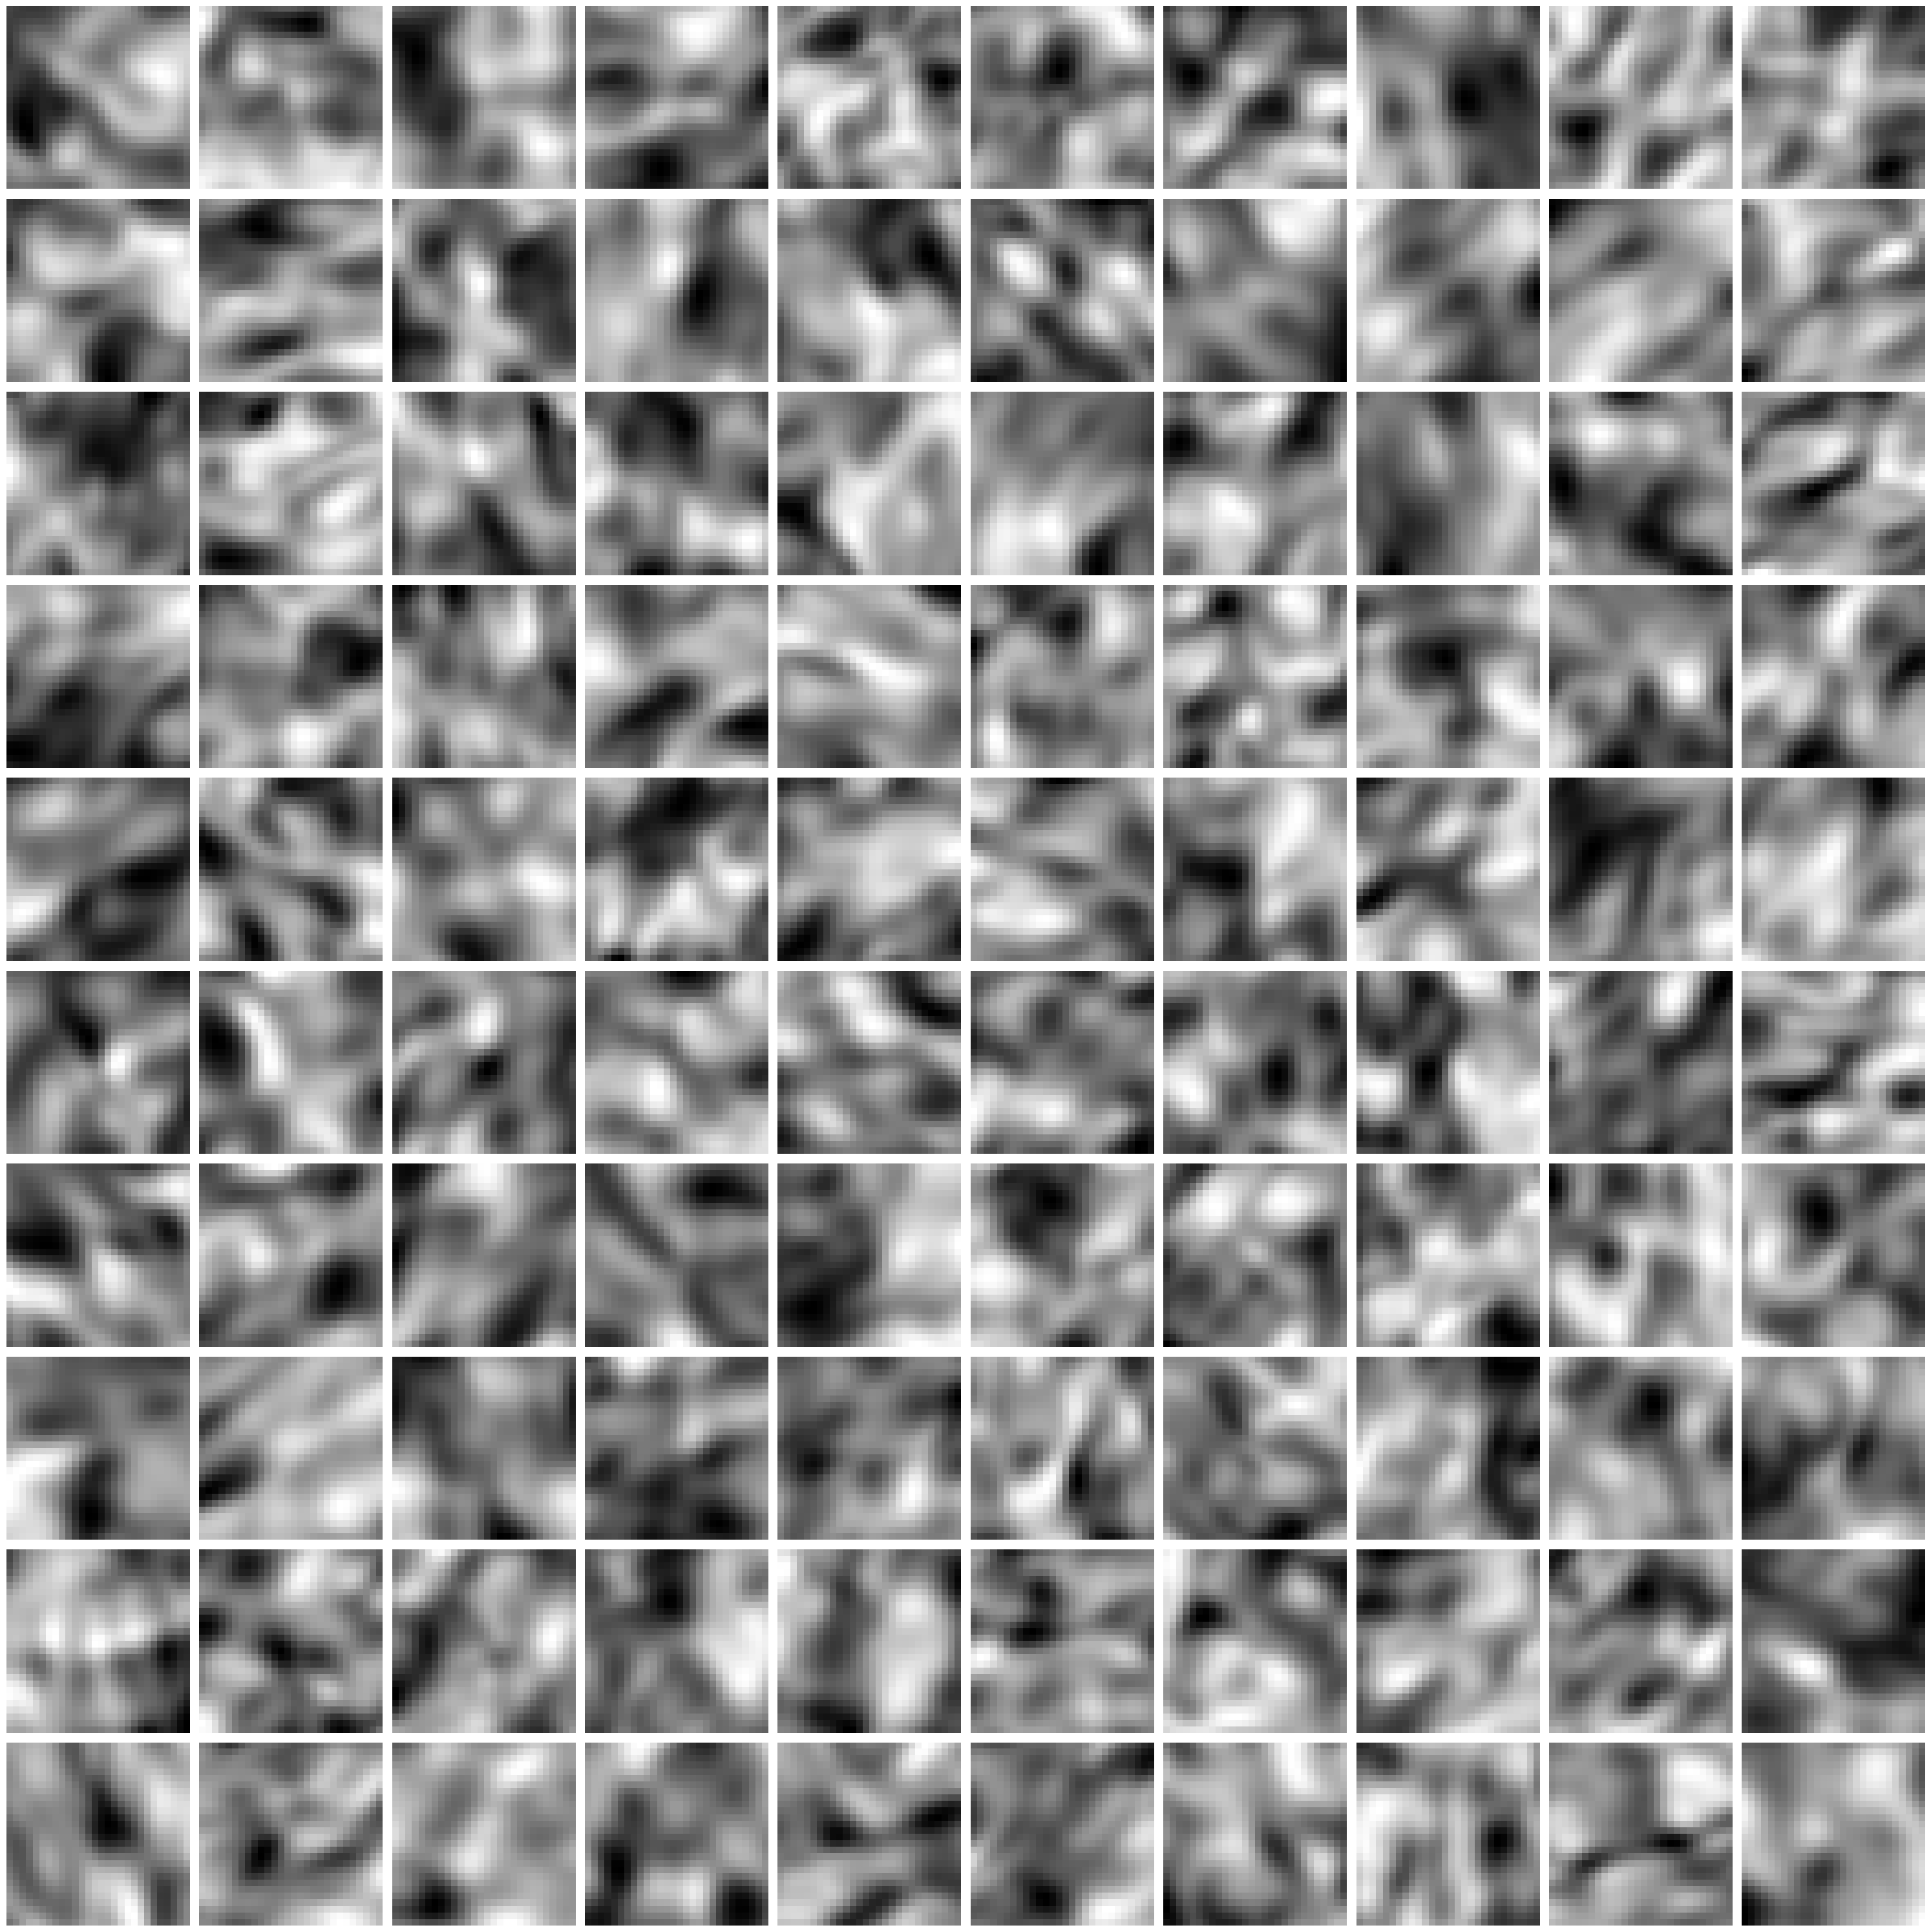

In [11]:
visualization_utils.plot_n_images(hyperdiffusion_images)

In [69]:
stable_hyperdiffusion_images = model_utils.generate_diffusion_images(stable_hyperdiffusion, mlp, n_samples, ref_cp=ref_cp)

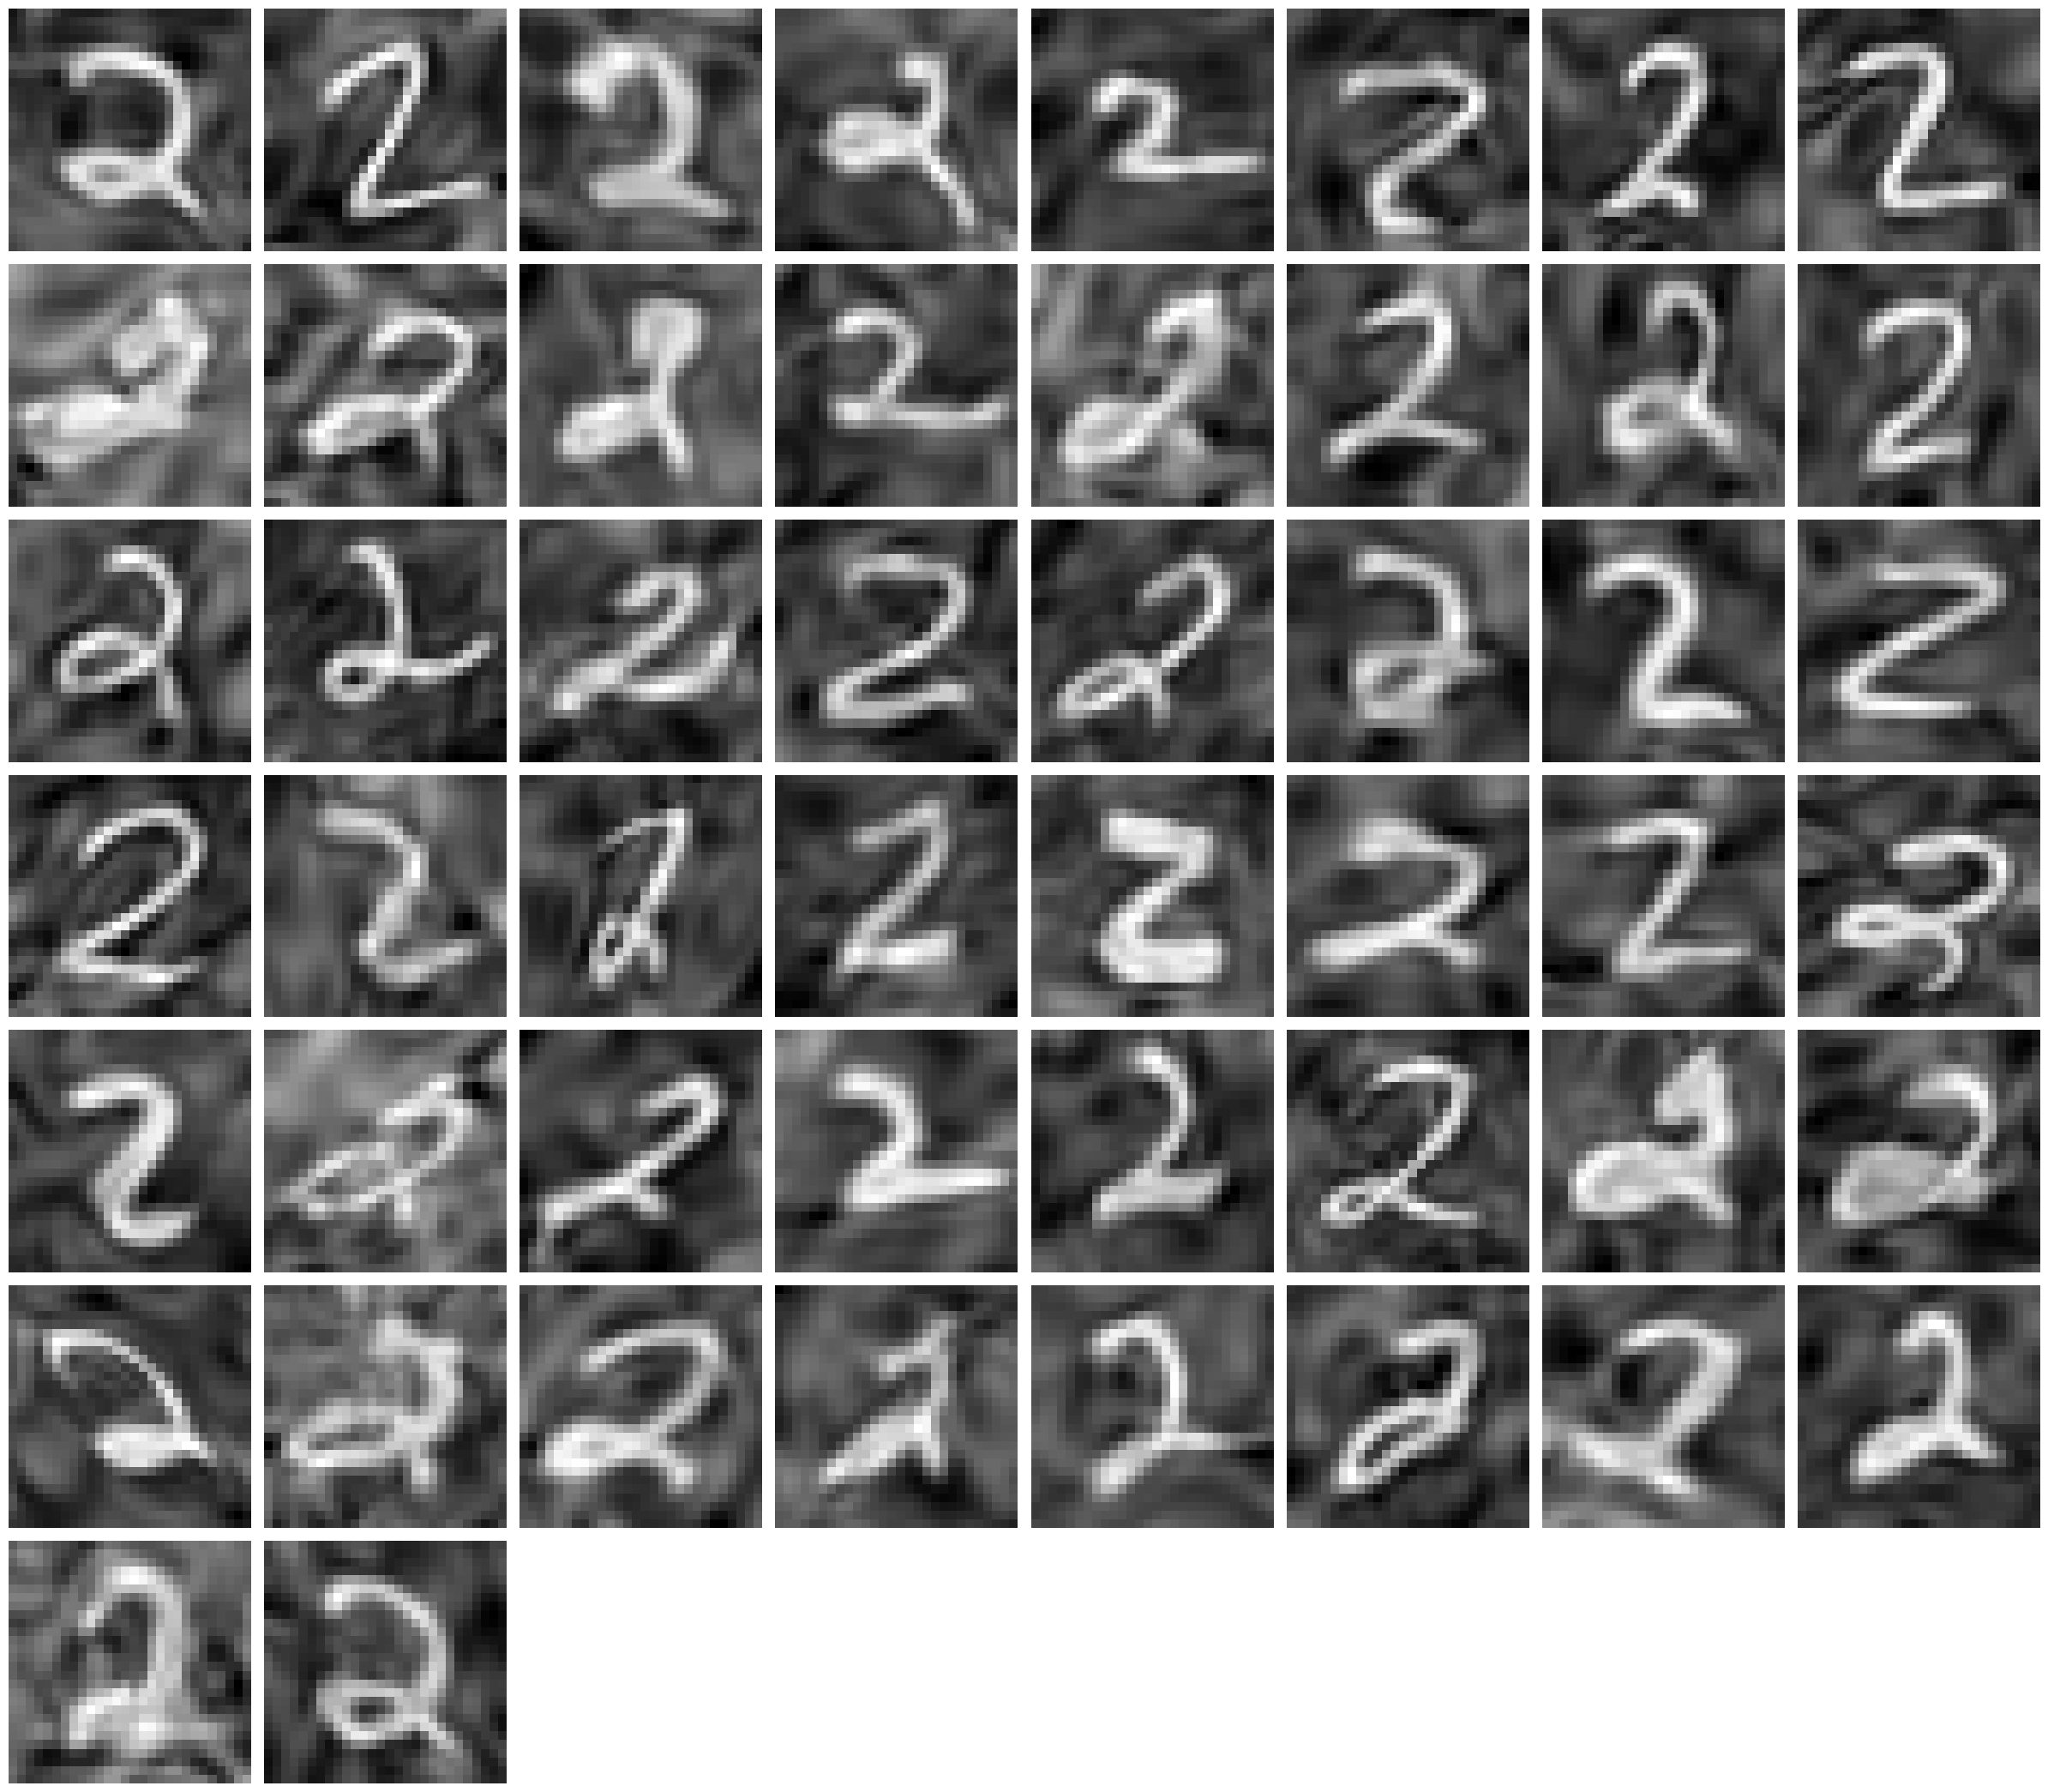

In [70]:
visualization_utils.plot_n_images(stable_hyperdiffusion_images)

### 5. Calculate metrics

#### 5.1 Image comparison

In [71]:
num_samples = 200
hyperdiffusion_results = hyperdiffusion.generate_samples(num_samples)
stable_hyperdiffusion_latent_outputs, stable_hyperdiffusion_results, stable_hyperdiffusion_positions = stable_hyperdiffusion.generate_samples(num_samples)

In [72]:
print(hyperdiffusion_results.shape)
print(stable_hyperdiffusion_results.shape)
print(stable_hyperdiffusion_latent_outputs.shape)

torch.Size([200, 1185])
torch.Size([200, 65, 33])
torch.Size([200, 65, 8])


In [ ]:
# Get n random samples from dataset
indices = random.sample(range(len(dataset_flattened)), num_samples)
dataset_samples = [dataset_flattened[i] for i in indices]
dataset_samples = torch.stack(dataset_samples)
print(dataset_samples.shape)

torch.Size([200, 1185])


In [78]:
stable_hyperdiffusion_results_flattened = [weights_to_flattened_weights(tokens_to_weights(t, p, ref_cp)) for t, p in zip(stable_hyperdiffusion_results, stable_hyperdiffusion_positions)]
stable_hyperdiffusion_results_flattened = torch.stack(stable_hyperdiffusion_results_flattened)
print(stable_hyperdiffusion_results_flattened.shape)

torch.Size([200, 1185])


In [83]:
# Generate images and stack to tensor
hyperdiffusion_images = [torch.from_numpy(model_utils.compute_image(mlp, flattened_weights_to_weights(s, mlp))) for s in hyperdiffusion_results]
hyperdiffusion_images = torch.stack(hyperdiffusion_images)
stable_hyperdiffusion_images = [torch.from_numpy(model_utils.compute_image(mlp, flattened_weights_to_weights(s, mlp))) for s in stable_hyperdiffusion_results_flattened]
stable_hyperdiffusion_images = torch.stack(stable_hyperdiffusion_images)
dataset_images = [torch.from_numpy(model_utils.compute_image(mlp, flattened_weights_to_weights(s, mlp))) for s in dataset_samples]
dataset_images = torch.stack(dataset_images)

##### Calculate FID scores:

In [88]:
fid_hyperdiffusion = metrics.calculate_fid(dataset_images, hyperdiffusion_images)
fid_stable_hyperdiffusion = metrics.calculate_fid(dataset_images, stable_hyperdiffusion_images)
print(f"FID Hyperdiffusion: {fid_hyperdiffusion}")
print(f"FID Stable Hyperdiffusion: {fid_stable_hyperdiffusion}")

FID Hyperdiffusion: 22.14436149597168
FID Stable Hyperdiffusion: 2.347438335418701


##### Calculate MSE scores:

In [89]:
mse_hyperdiffusion = metrics.calculate_mse(dataset_images, hyperdiffusion_images)
mse_stable_hyperdiffusion = metrics.calculate_mse(dataset_images, stable_hyperdiffusion_images)
print(f"MSE Hyperdiffusion: {mse_hyperdiffusion}")
print(f"MSE Stable Hyperdiffusion: {mse_stable_hyperdiffusion}")

MSE Hyperdiffusion: 0.40297791361808777
MSE Stable Hyperdiffusion: 0.15483467280864716


##### Calculate the Minimum Matching Distance

In [91]:
mmd_hyperdiffusion = metrics.compute_mmd(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
mmd_stable_hyperdiffusion = metrics.compute_mmd(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"Minimum Matching Distance Hyperdiffusion: {mmd_hyperdiffusion}")
print(f"Minimum Matching Distance Stable Hyperdiffusion: {mmd_stable_hyperdiffusion}")

Minimum Matching Distance Hyperdiffusion: 0.10000001639127731
Minimum Matching Distance Stable Hyperdiffusion: 0.10063296556472778


##### Calculate the coverage

In [97]:
coverage_hyperdiffusion = metrics.compute_coverage(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
coverage_stable_hyperdiffusion = metrics.compute_coverage(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"Coverage Hyperdiffusion: {coverage_hyperdiffusion}")
print(f"Coverage Stable Hyperdiffusion: {coverage_stable_hyperdiffusion}")

Coverage Hyperdiffusion: 0.06
Coverage Stable Hyperdiffusion: 0.995


##### Calculate the 1-Nearest-Neighbor Accuracy

In [98]:
nna_hyperdiffusion = metrics.compute_1nna(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
nna_stable_hyperdiffusion = metrics.compute_1nna(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"1-Nearest-Neighbor Accuracy Hyperdiffusion: {nna_hyperdiffusion}")
print(f"1-Nearest-Neighbor Accuracy Stable Hyperdiffusion: {nna_stable_hyperdiffusion}")

1-Nearest-Neighbor Accuracy Hyperdiffusion: 0.9725
1-Nearest-Neighbor Accuracy Stable Hyperdiffusion: 0.5375


##### Calculate the novelty

In [102]:
# NOTE: maybe we should use the whole training dataset here
novelty_hyperdiffusion = metrics.detect_novelty(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
novelty_stable_hyperdiffusion = metrics.detect_novelty(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"Novelty Hyperdiffusion: {novelty_hyperdiffusion[0].sum()} of {len(novelty_hyperdiffusion[0])}")
print(f"Novelty Stable Hyperdiffusion: {novelty_stable_hyperdiffusion[0].sum()} of {len(novelty_stable_hyperdiffusion[0])}")

Novelty Hyperdiffusion: 200 of 200
Novelty Stable Hyperdiffusion: 9 of 200


In [105]:
novelty_hyperdiffusion = metrics.novelty_svm(dataset_images.reshape(dataset_images.shape[0], -1), hyperdiffusion_images.reshape(hyperdiffusion_images.shape[0], -1))
novelty_stable_hyperdiffusion = metrics.novelty_svm(dataset_images.reshape(dataset_images.shape[0], -1), stable_hyperdiffusion_images.reshape(stable_hyperdiffusion_images.shape[0], -1))
print(f"Novelty Hyperdiffusion: {novelty_hyperdiffusion}")
print(f"Novelty Stable Hyperdiffusion: {novelty_stable_hyperdiffusion}")

Novelty Hyperdiffusion: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
Novelty Stable Hyperdiffusion: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
  1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

#### 5.2 Weights comparison

In [106]:
#TODO:

### 6. VAE Latent Space

#### Sample from latent space

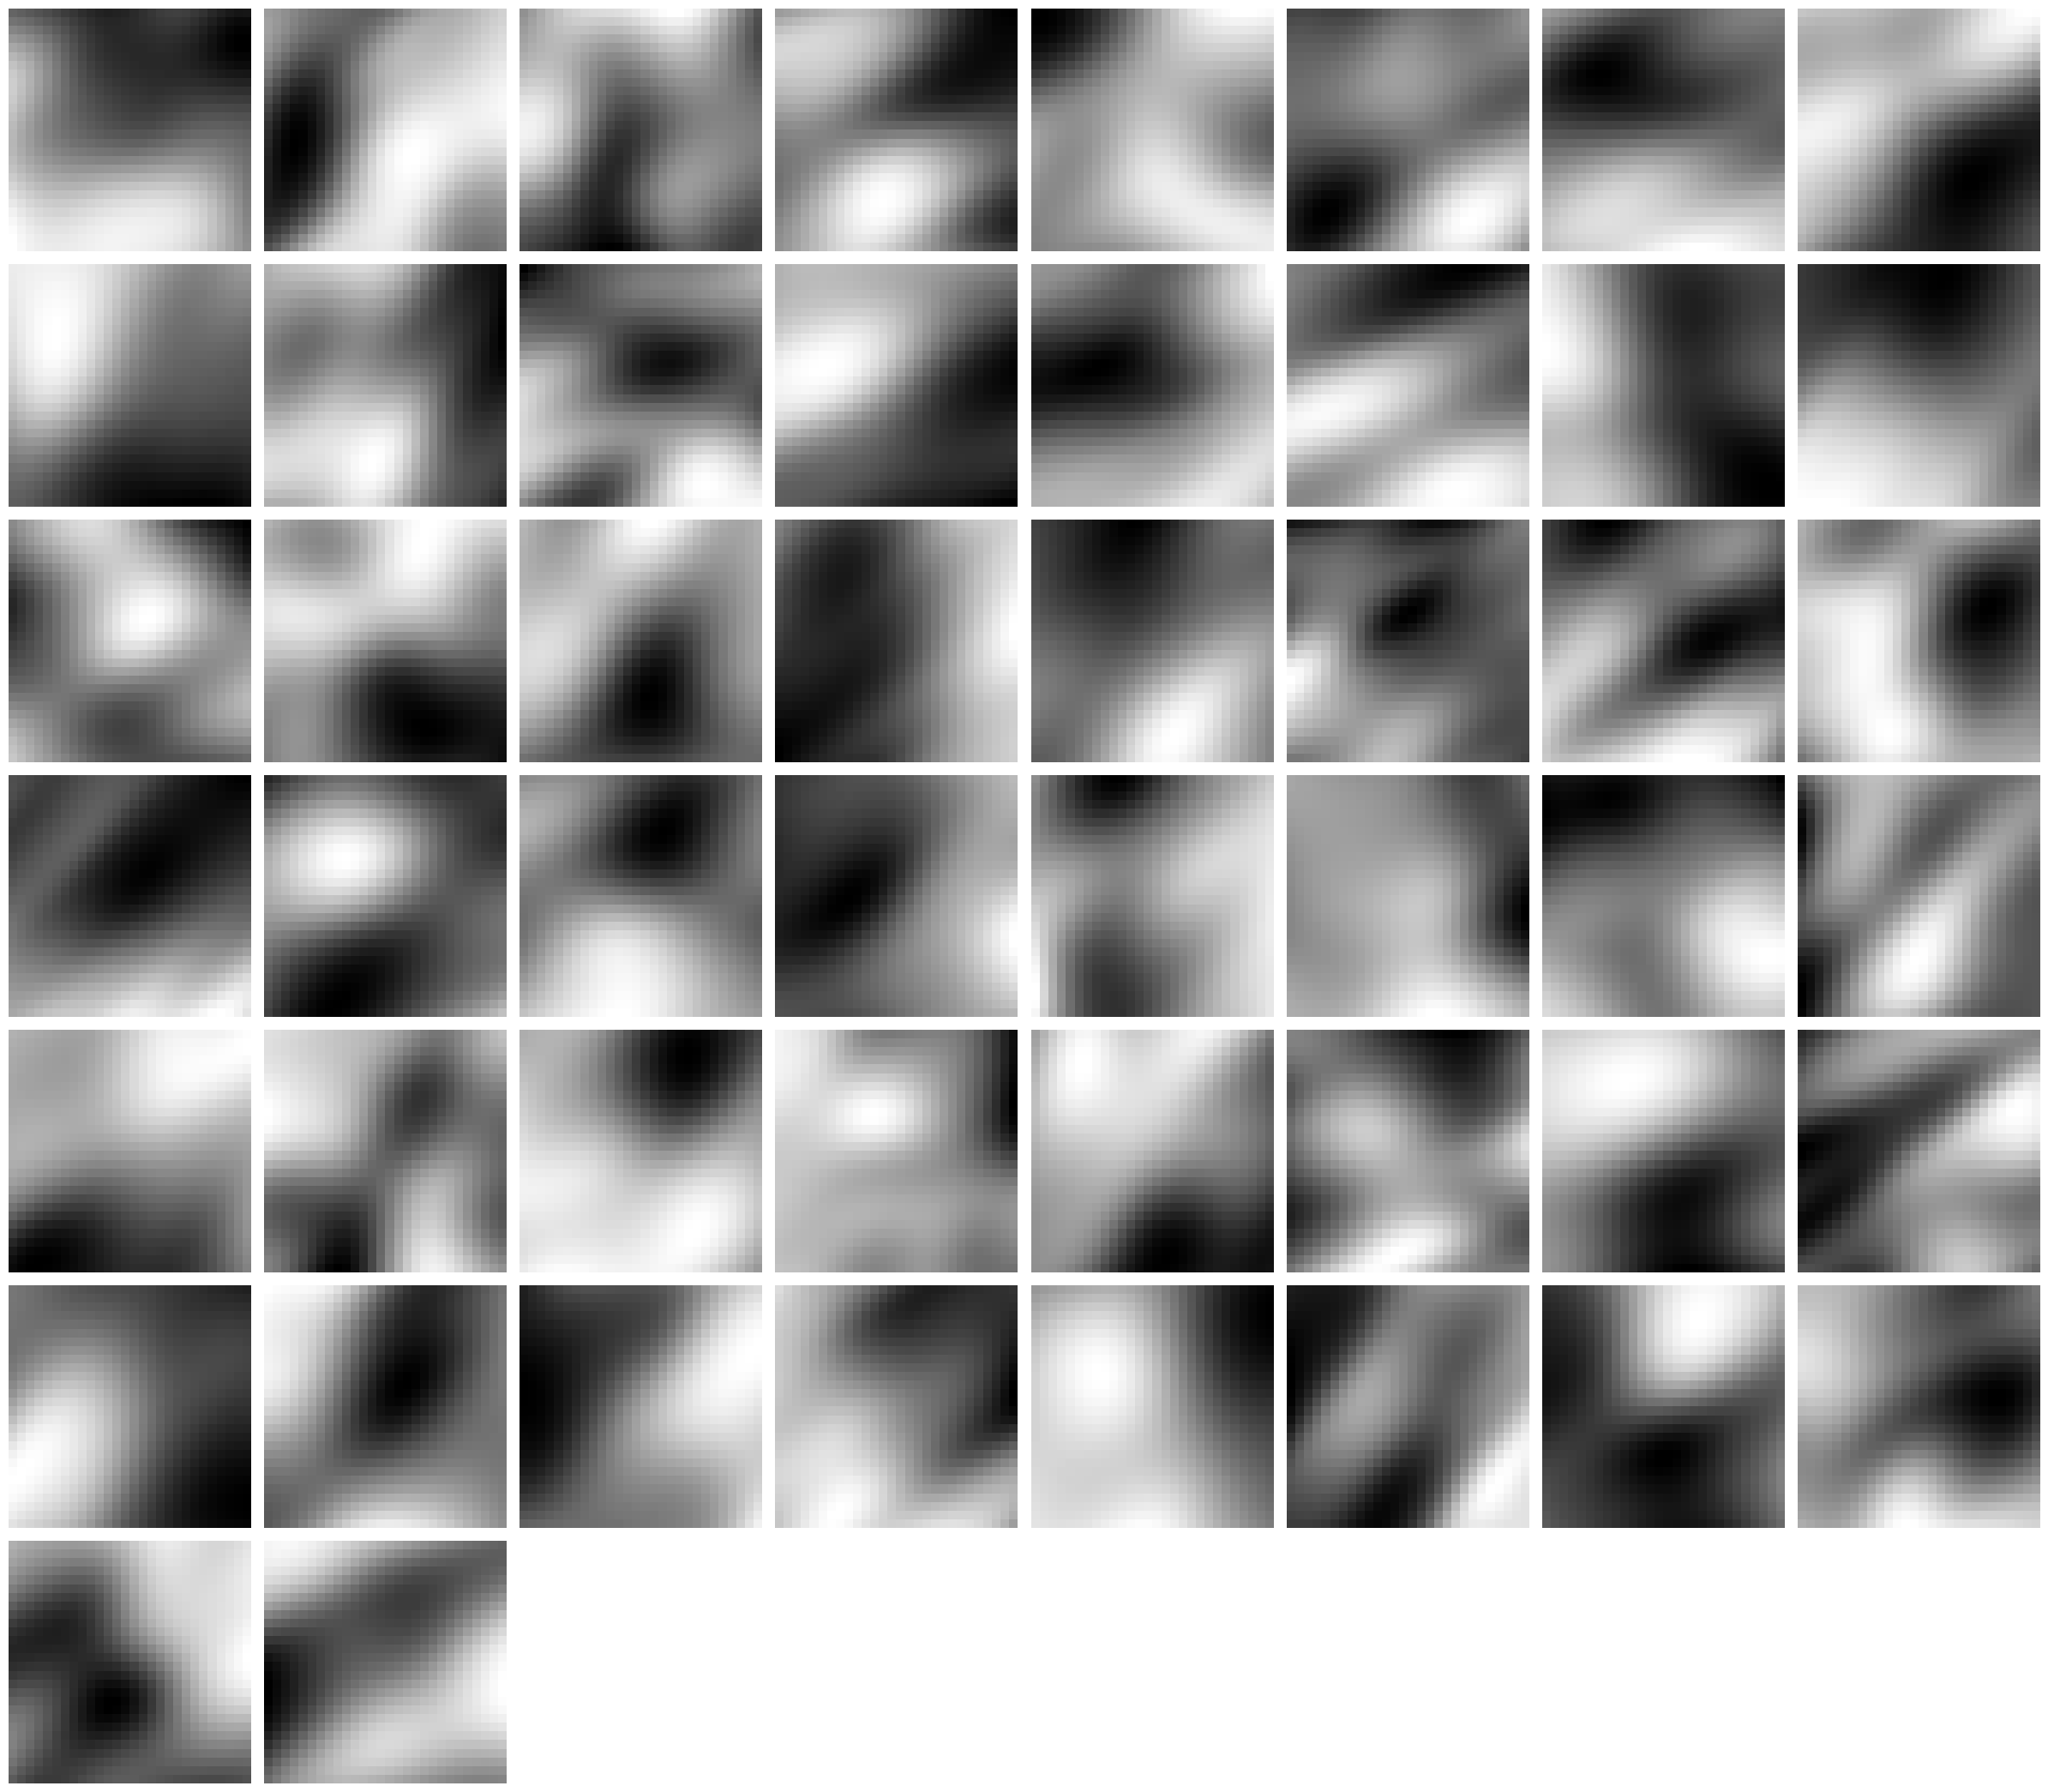

In [107]:
num_samples = 50
latent_images = model_utils.sample_from_latent_space(
    vae, mlp, ref_cp, dataset_tokenized[0][2], config_ae.model.n_tokens, config_ae.model.latent_dim, n_samples
)
visualization_utils.plot_n_images(latent_images)

##### Interpolate latent space

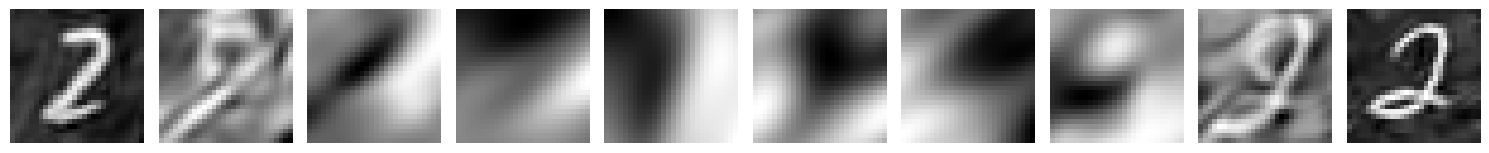

In [117]:
num_interpolation_steps = 10

latent_vectors = [dataset_tokenized[0][0], dataset_tokenized[1][0]]
latent_positions = [dataset_tokenized[0][2], dataset_tokenized[1][2]]
latent_vectors = torch.stack(latent_vectors)
latent_positions = torch.stack(latent_positions)

vae.eval()
with torch.no_grad():
    latent_vector, _, _ = vae.encoder(latent_vectors, latent_positions)

latent_images = model_utils.interpolate_latent_space(
    latent_vector[0], latent_vector[1], num_interpolation_steps, dataset_tokenized[0][2], vae, ref_cp, mlp
)
visualization_utils.plot_n_images(latent_images, row=True)

### 7. Get nearest neighbors

In [123]:
num_samples = 30
k = 2
dataset_images, hyperdifusion_images, mse_images, mse_weights, distances = model_utils.generate_nearest_neighbors(hyperdiffusion, 
                                                                                                                  inr=mlp,
                                                                                                                  dataset=dataset_flattened,
                                                                                                                  num_samples=30,
                                                                                                                  k=k)

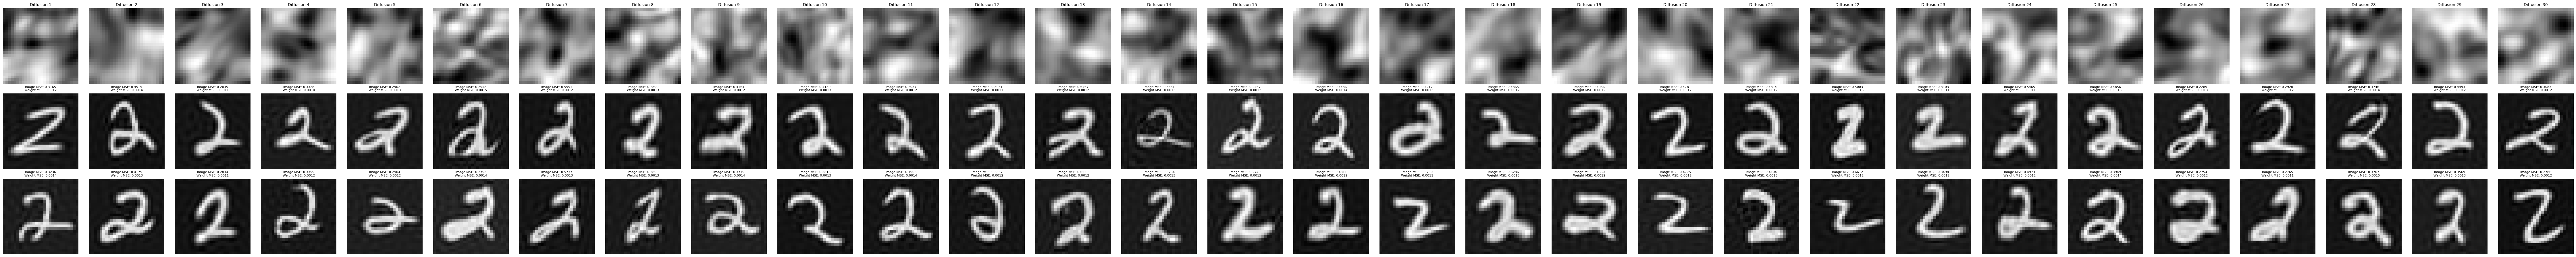

In [124]:
visualization_utils.plot_diffusion_knn(
    hyperdifusion_images,
    dataset_images,
    mse_images,
    mse_weights,
    k=k,
    num_samples=num_samples
)

In [125]:
dataset_images, stable_hyperdifusion_images, mse_images, mse_weights, distances = model_utils.generate_nearest_neighbors(stable_hyperdiffusion, 
                                                                                                                  inr=mlp,
                                                                                                                  dataset=dataset_tokenized,
                                                                                                                  num_samples=30,
                                                                                                                  k=k)

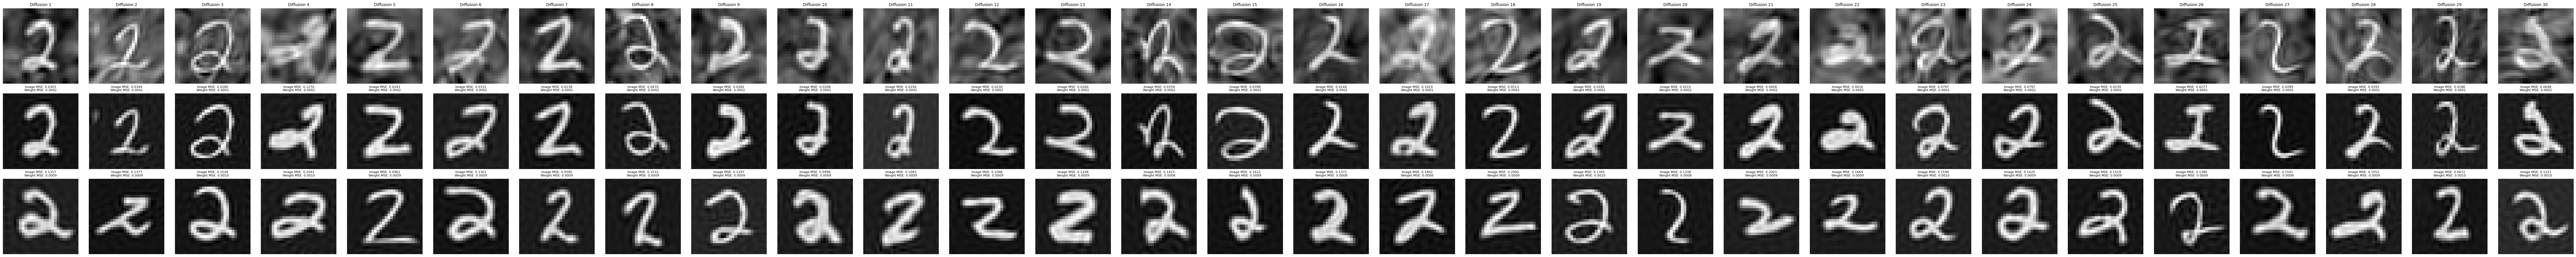

In [126]:
visualization_utils.plot_diffusion_knn(
    stable_hyperdifusion_images,
    dataset_images,
    mse_images,
    mse_weights,
    k=k,
    num_samples=num_samples
)